## Credit Card Transaction Fraud Exploratory Data Analysis

In this jupyter notebook I will analyze the credit card transaction dataset to later create a Machine Learning model that classsifies the transactions.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [119]:
df = pd.read_csv('../data/synthetic_transactions.csv')
df.head()

,transaction_id,user_id,amount,currency,category,timestamp,location,is_fraud
0,81eb959b-22d3-4e31-8378-d37af09c3ac9,1048,408.98,USD,Entertainment,2025-08-28T14:51:42.963443,BS,0
1,43749e52-58fc-48f0-87b2-7ea914f4ca26,1919,68.08,USD,Entertainment,2025-08-14T19:03:42.964477,RS,0
2,fa4e552f-24d3-4b7f-8bbb-43f932414c2d,1356,167.99,USD,Books,2025-08-12T09:01:42.964477,MU,0
3,bf80c618-5825-4fde-a8d4-8efa619c56d6,2300,24.50,USD,Parking,2025-08-15T01:09:42.964477,SN,0
4,b3c9c70c-de55-46e5-a378-8341c2298988,2552,25.37,USD,Health & Fitness,2025-08-08T10:35:42.964477,TJ,0


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  10000 non-null  object 
 1   user_id         10000 non-null  int64  
 2   amount          10000 non-null  float64
 3   currency        10000 non-null  object 
 4   category        10000 non-null  object 
 5   timestamp       10000 non-null  object 
 6   location        9934 non-null   object 
 7   is_fraud        10000 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 625.1+ KB


In [121]:
# Count the number of frauds
fraud_count = df["is_fraud"].sum()
fraud_pct = fraud_count / len(df) * 100

print(f"The dataset has: {fraud_count} frauds out of {df.shape[0]}, i.e. ({fraud_pct:.2f}%)")

The dataset has: 375 frauds out of 10000, i.e. (3.75%)


In [122]:
# Null values
df.isnull().sum()

transaction_id     0
user_id            0
amount             0
currency           0
category           0
timestamp          0
location          66
is_fraud           0
dtype: int64

The only column that has null values is the location one, since it only represents a small part of the dataset we can ignore it and put 'unkwon' on the null values.

In [123]:
df[df['location'].isna()].head()

,transaction_id,user_id,amount,currency,category,timestamp,location,is_fraud
210,bf1a6f28-0364-467d-a7f5-9c3c604f86fd,2506,347.97,USD,Education,2025-08-27T18:49:42.970749,NaN,0
331,c3ced7da-fadb-4e17-aa95-c6e599f78b80,237,355.34,USD,Entertainment,2025-08-26T21:17:42.974881,NaN,0
437,8222dc0e-d678-4b60-8947-58a0cbe2ecb2,2538,83.97,USD,Clothing,2025-08-09T01:36:42.978863,NaN,0
461,6c2d2d51-359b-4449-ad40-8f06ec05683b,1827,3.93,USD,Night Clubs,2025-08-29T03:08:42.978863,NaN,0
1010,ddac3b8d-404d-4772-a1a9-69e8752464e2,920,49.00,USD,Pet Supplies,2025-08-28T18:34:42.999935,NaN,0


In [124]:
# Input the null values in the location column with 'unkwon'
df['location'] = df['location'].fillna(value='unkwon')

## Users

Now lets inspect the number of users we have and the frequent users.

In [125]:
n_users = len(df['user_id'].unique())
print(f"There are {n_users} users")

There are 2910 users


In [126]:
# Count the number of transactions per user
transactions_per_user = df['user_id'].value_counts()
transactions_per_user.describe()

count    2910.000000
mean        3.436426
std         1.757344
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        11.000000
Name: count, dtype: float64

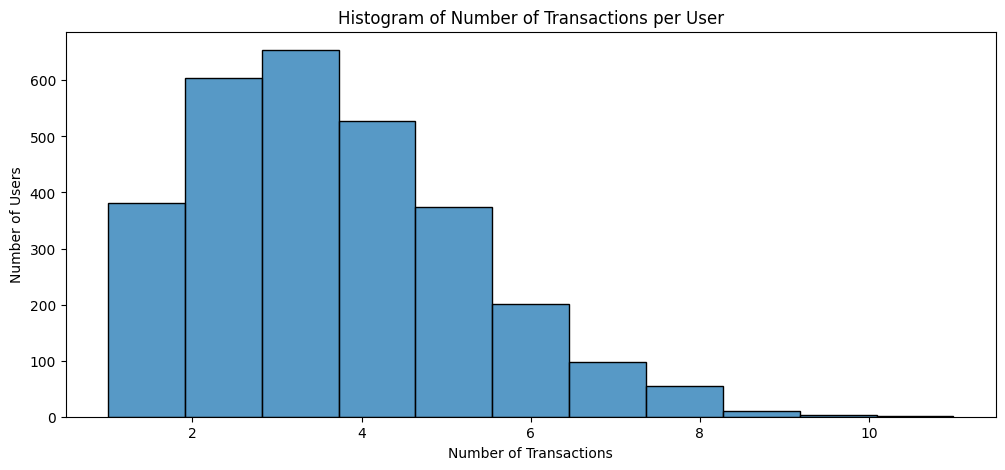

In [127]:
plt.figure(figsize=(12, 5))
sns.histplot(transactions_per_user, bins=transactions_per_user.max())
plt.title('Histogram of Number of Transactions per User')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Users')
plt.show()

- On average, each user made **3.43 transactions**.
- **50% of users** made **3 or fewer** transactions (median).
- **25% of users** made from **3 to 5** transactions.
- The **maximum** number of transactions made by a single user was **11**.

This indicates a moderately skewed distribution, where most users have relatively few transactions, but a small number are more active.


In [128]:
# Number of frauds per user
frauds_per_user = df[df['is_fraud'] == 1]['user_id'].value_counts()
frauds_per_user.describe()

count    344.000000
mean       1.090116
std        0.367032
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: count, dtype: float64

In [129]:
print(f'{frauds_per_user.count()} Users received frauds')
print(f"There are {(frauds_per_user > 1).sum()} users with more than 1 fraud, meaning {(frauds_per_user > 1).sum() / frauds_per_user.count() * 100:.2f}% of users with frauds have more than 1 fraud")

344 Users received frauds
There are 25 users with more than 1 fraud, meaning 7.27% of users with frauds have more than 1 fraud


As expected, only a small percentage of users experienced more than one fraudulent transaction. This suggests that it is uncommon for a user to be targeted multiple times. 

This insight is valuable for our machine learning model, as it indicates that we should focus more on the **individual transactions** rather than modeling user-specific behavior.

## Transaction Amounts

Let's now explore the **amount of money** involved in the transactions. This analysis will help us understand the distribution of transaction values and identify any unusual or potentially fraudulent patterns.


In [130]:
df['amount'].describe()

count    10000.000000
mean       170.331467
std        410.488761
min          0.020000
25%         20.137500
50%         55.535000
75%        155.560000
max      10725.450000
Name: amount, dtype: float64

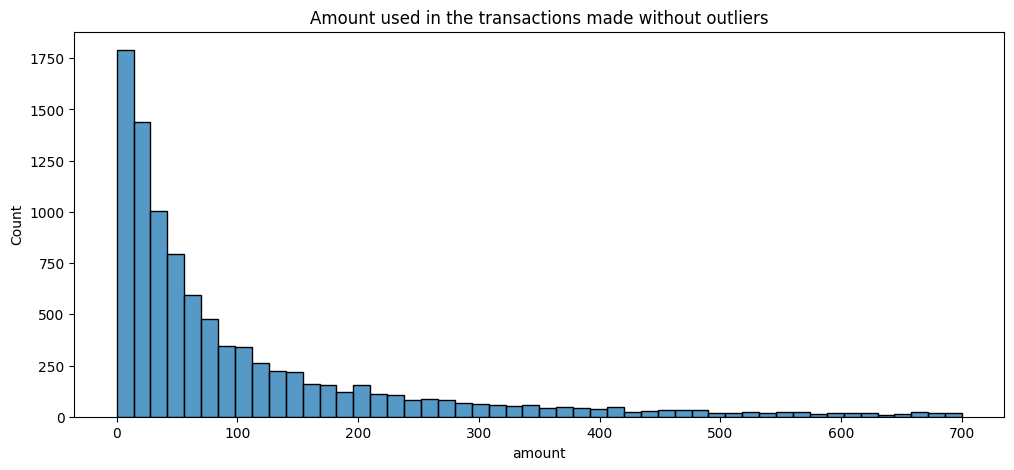

In [131]:
plt.figure(figsize=(12, 5))
sns.histplot(x = df[df['amount'] < df['amount'].quantile(0.95)]['amount'], bins=50)
plt.title('Amount used in the transactions made without outliers')
plt.show()

- Most transactions are relatively small — the **median is $55.50**, meaning that 50% of all transactions were for $55.50 or less.
- Approximately **25% of transactions** fall between **$56 and $155** (the interquartile range).
- The **remaining 25%** exceed **$155**, with some **extremely high-value transactions** reaching up high-value transactions (max = 10,725.45), which significantly increase the mean and standard deviation.

This skewness justifies the need to visualize the data both with and without outliers, as done in the previous histograms.

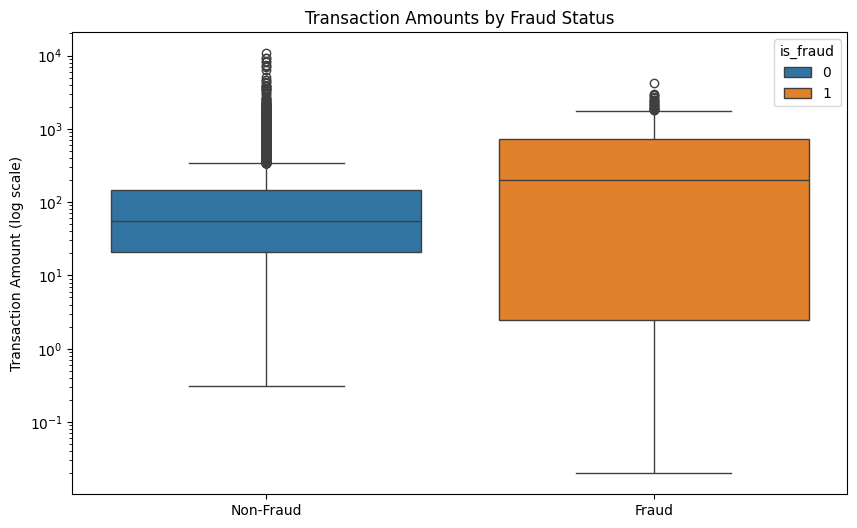

In [132]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='is_fraud', 
    y='amount', 
    data=df,
    hue='is_fraud',
)
plt.yscale("log")  
plt.title("Transaction Amounts by Fraud Status")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.ylabel("Transaction Amount (log scale)")
plt.xlabel("")
plt.show()

This boxplot compares the distribution of **transaction amounts** between **non-fraudulent** and **fraudulent** transactions.

- **Non-Fraudulent transactions (blue):**  
  - Most are concentrated at lower amounts.  
  - The median is relatively small, but there are many **extreme outliers**, reaching very high values (above 10,000).  
  - This indicates that regular customer behavior usually involves small purchases, with some occasional very large ones.  

- **Fraudulent transactions (orange):**  
  - The median transaction amount is **significantly higher** than in the non-fraud group.  
  - The spread is wider and the distribution shows **larger values more frequently**, though still with fewer extreme outliers than in the non-fraud group.  
  - This suggests that fraudsters tend to target **medium-to-large transactions**, making them stand out compared to typical spending patterns.  

 
The visualization supports the idea that **transaction amount is a key feature** for fraud detection. Fraudulent transactions generally involve **higher amounts** and show a distinct distribution from normal spending, even when accounting for extreme outliers.

### Amounts of the frauds

In [133]:
df[df['is_fraud'] == 1]['amount'].describe()

count     375.000000
mean      465.830293
std       657.235384
min         0.020000
25%         2.470000
50%       201.680000
75%       724.465000
max      4158.990000
Name: amount, dtype: float64

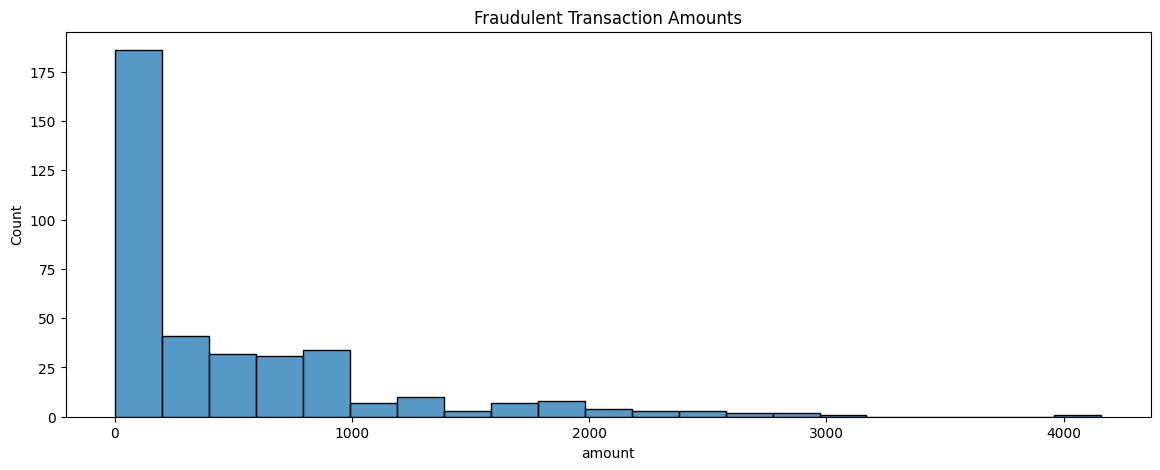

In [134]:
# Explorw the amounts of the frauds
plt.figure(figsize=(14, 5))
sns.histplot(x=df[df['is_fraud'] == 1]['amount'])
plt.title('Fraudulent Transaction Amounts')
plt.show()

The histogram above shows the distribution of amounts for fraudulent transactions. The majority of fraudulent transactions involve **very small amounts**, typically concentrated close to zero. A large spike is visible at the lower end of the scale, where transactions below \$10–\$20 dominate. However, there are also a few cases of fraud involving much larger amounts, with the maximum recorded fraudulent transaction reaching over **\$4,600**.

From the descriptive statistics:

- **Count:** 345 fraudulent transactions  
- **Mean amount:** \$465.83  
- **Median amount (50%):** \$201.68 (much smaller than the mean, indicating a skewed distribution)  
- **Standard deviation:** \$657.23, reflecting high variability  
- **25th percentile:** \$2.47  
- **75th percentile:** \$724.46  
- **Minimum:** \$0.02
- **Maximum:** \$4,158.99  

These values confirm that the data is **highly right-skewed**: while most fraudulent transactions are of very small amounts, there are rare but significant outliers with very large amounts. This pattern suggests that fraudsters might commonly test with low-value transactions (possibly to avoid detection) but occasionally attempt much larger transactions once smaller ones succeed.

## Categories

In [135]:
print(f"There are {df['category'].nunique()} categories")

There are 30 categories


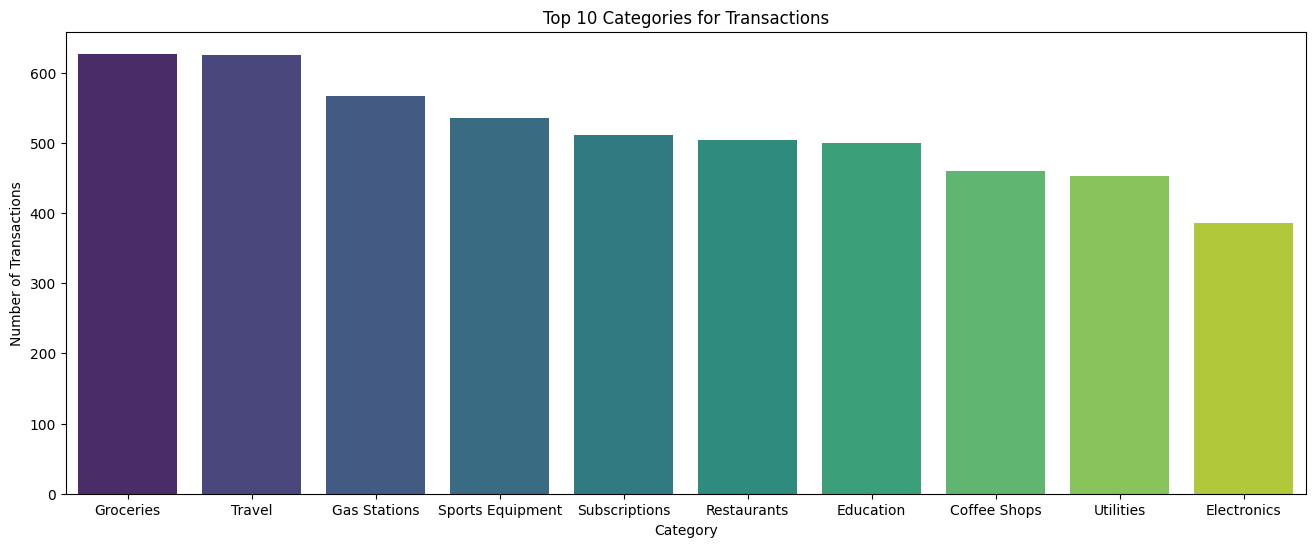

In [136]:
top_categories = df['category'].value_counts().head(10)

plt.figure(figsize=(16, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis', hue=top_categories.index)
plt.title('Top 10 Categories for Transactions')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.show()

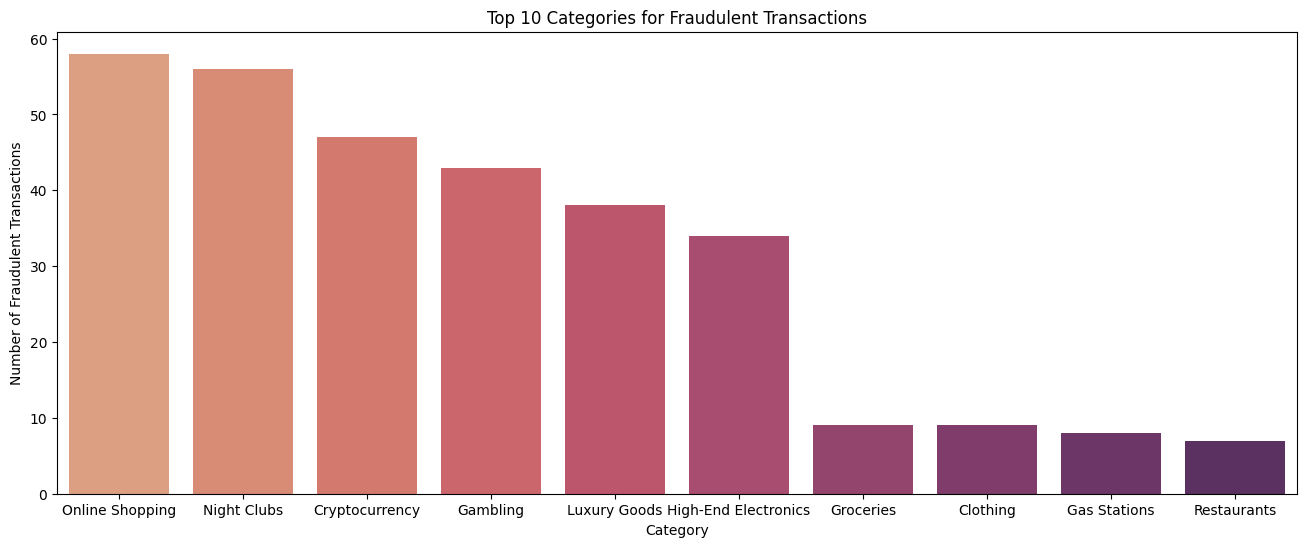

In [137]:
top_categories_fraud = df[df['is_fraud']==1]['category'].value_counts().head(10)

plt.figure(figsize=(16, 6))
sns.barplot(x=top_categories_fraud.index, y=top_categories_fraud.values, palette='flare', hue=top_categories_fraud.index)
plt.title('Top 10 Categories for Fraudulent Transactions')
plt.xlabel('Category')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

The difference between the categories involved in frauds and normal purchases is very bin, the top 5 most common categories in normal transactions are: *Groceries, Tarvel, Gas Station, Sports, Suscriptions*, while in fraudulent transactions are: *Online Shopping, Night Clubs, Cryptocurrency, Gambling, Luxury Goods* so the model will likely identify very fast the frauds considering this categories information.

In [138]:
def plot_top_categories(df, fraud_type='non-fraud', top_n=5):
    """
    Plots the top N transaction categories based on fraud or non-fraud frequency.

    Parameters:
    - df: pandas DataFrame with 'category' and 'is_fraud' columns
    - fraud_type: 'fraud' or 'non-fraud' to indicate which type of transaction to base top categories on
    - top_n: number of top categories to display (default is 5)
    """

    # Validate input
    if fraud_type not in ['fraud', 'non-fraud']:
        raise ValueError("fraud_type must be either 'fraud' or 'non-fraud'")

    # Determine fraud value
    fraud_value = 1 if fraud_type == 'fraud' else 0

    # 1. Get top N categories based on the selected fraud type
    top_categories = (
        df[df['is_fraud'] == fraud_value]['category']
        .value_counts()
        .head(top_n)
        .index
    )

    # 2. Filter dataset for only those categories
    filtered_df = df[df['category'].isin(top_categories)]

    # 3. Count fraud vs non-fraud per category
    counts = (
        filtered_df
        .groupby(['category', 'is_fraud'])
        .size()
        .reset_index(name='count')
    )

    # 4. Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='category',
        y='count',
        hue='is_fraud',
        data=counts,
        palette={0: 'skyblue', 1: 'salmon'}
    )

    title_type = "Fraudulent" if fraud_value == 1 else "Non-Fraudulent"
    plt.title(f"Top {top_n} {title_type} Categories: Fraud vs Non-Fraud")
    plt.xlabel("Category")
    plt.ylabel("Number of Transactions")

    # Custom legend
    blue_patch = mpatches.Patch(color='skyblue', label='Non-Fraud')
    red_patch = mpatches.Patch(color='salmon', label='Fraud')
    plt.legend(handles=[blue_patch, red_patch], title="Fraud Status")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

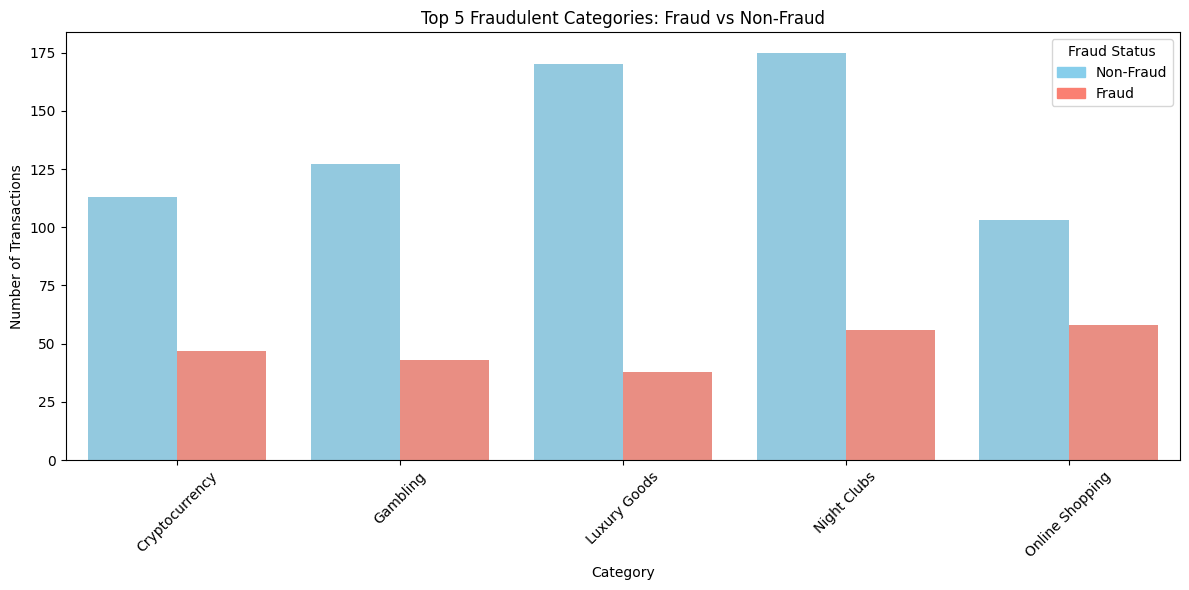

In [139]:
# Show top 5 fraud-prone categories
plot_top_categories(df, fraud_type='fraud')

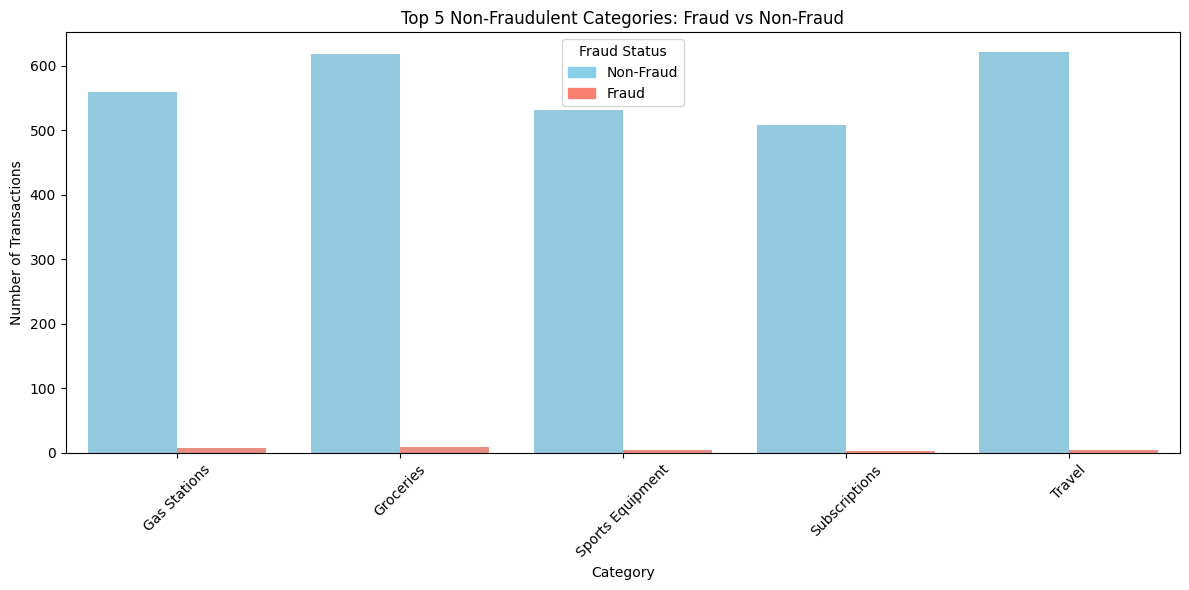

In [140]:
# Show top 5 most common categories in non-fraud transactions
plot_top_categories(df, fraud_type='non-fraud')

## Timestamp

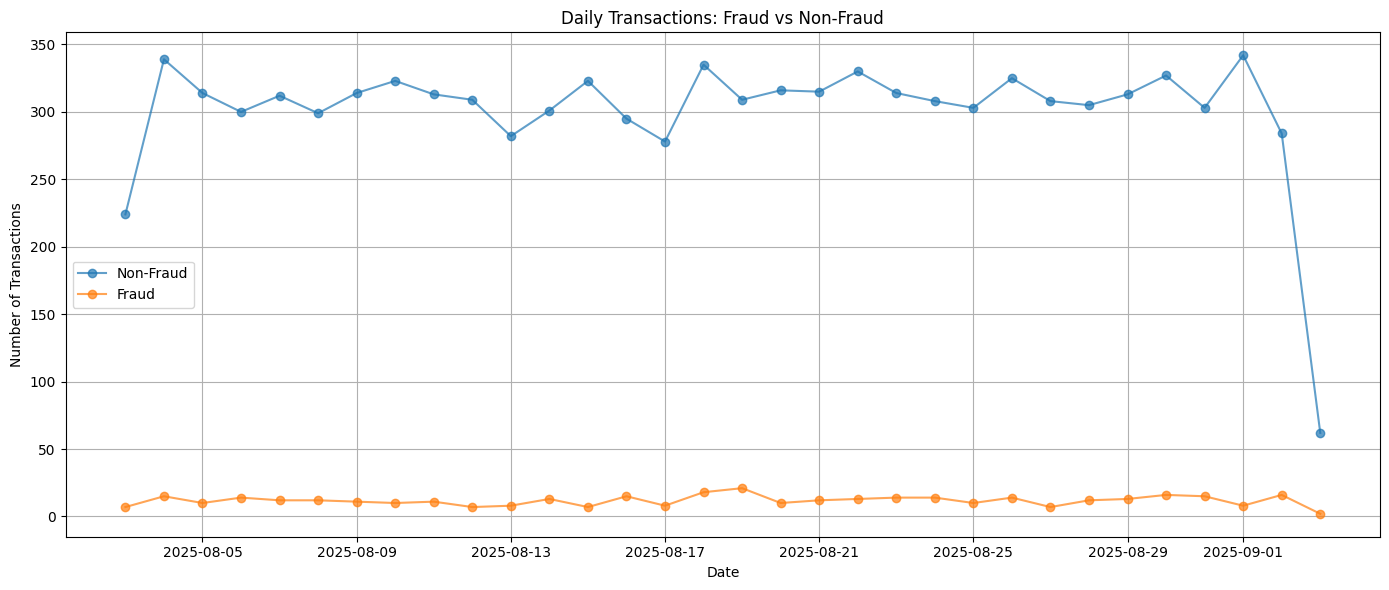

In [141]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group by time and type of transaction
df['date'] = df['timestamp'].dt.date
daily_counts = df.groupby(['date', 'is_fraud']).size().reset_index(name='count')

pivot_df = daily_counts.pivot(index='date', columns='is_fraud', values='count').fillna(0)
pivot_df.columns = ['Non-Fraud', 'Fraud']

# Plot
plt.figure(figsize=(14, 6))
pivot_df.plot(kind='line', ax=plt.gca(), marker='o', alpha=0.7)
plt.title('Daily Transactions: Fraud vs Non-Fraud')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

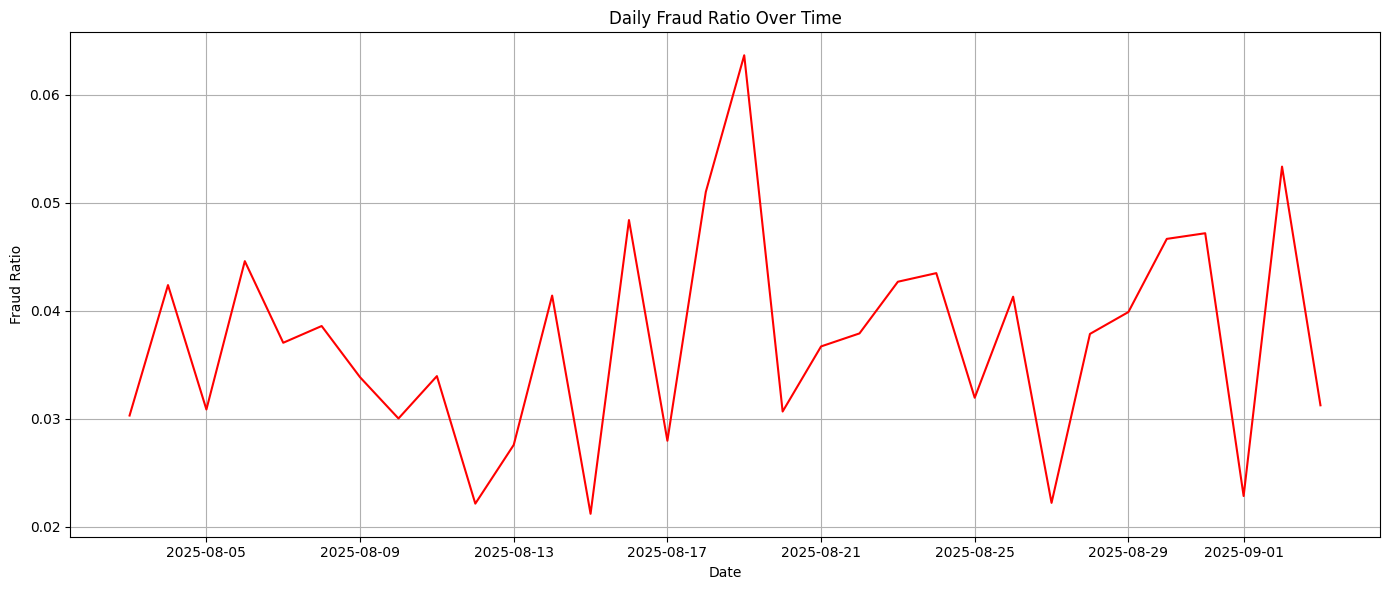

In [142]:
# Group by dtae
daily_totals = df.groupby(df['timestamp'].dt.date).agg(
    total_transactions=('is_fraud', 'count'),
    fraud_transactions=('is_fraud', 'sum')
)

# Compute the proportion
daily_totals['fraud_ratio'] = daily_totals['fraud_transactions'] / daily_totals['total_transactions']

# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_totals.index, daily_totals['fraud_ratio'], color='red')
plt.title('Daily Fraud Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


## Location

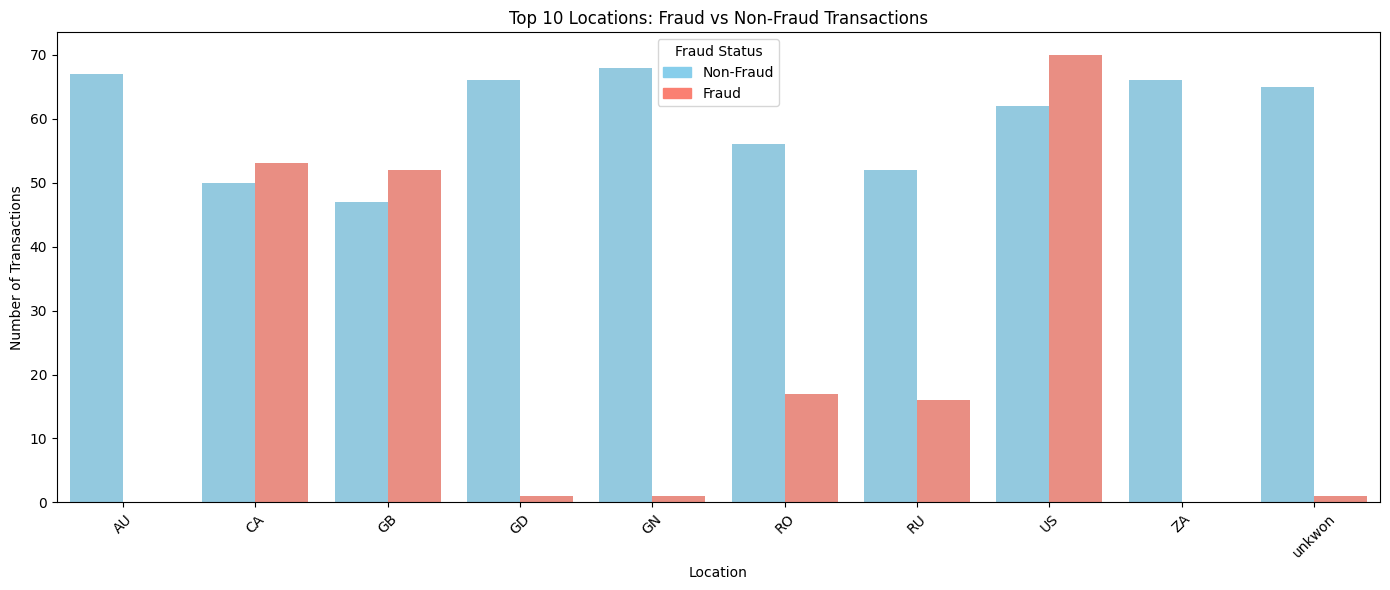

In [143]:
# Location
location_counts = (
    df.groupby(['location', 'is_fraud'])
    .size()
    .reset_index(name='count')
)

# Top 10 locations by total transactions
top_locations = (
    df['location'].value_counts()
    .head(10)
    .index
)

# Filtramos
location_counts = location_counts[location_counts['location'].isin(top_locations)]

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    x='location',
    y='count',
    hue='is_fraud',
    data=location_counts,
    palette={0: 'skyblue', 1: 'salmon'}
)

plt.title('Top 10 Locations: Fraud vs Non-Fraud Transactions')
plt.xlabel('Location')
plt.ylabel('Number of Transactions')

# Custom legend
blue_patch = mpatches.Patch(color='skyblue', label='Non-Fraud')
red_patch = mpatches.Patch(color='salmon', label='Fraud')
plt.legend(handles=[blue_patch, red_patch], title="Fraud Status")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

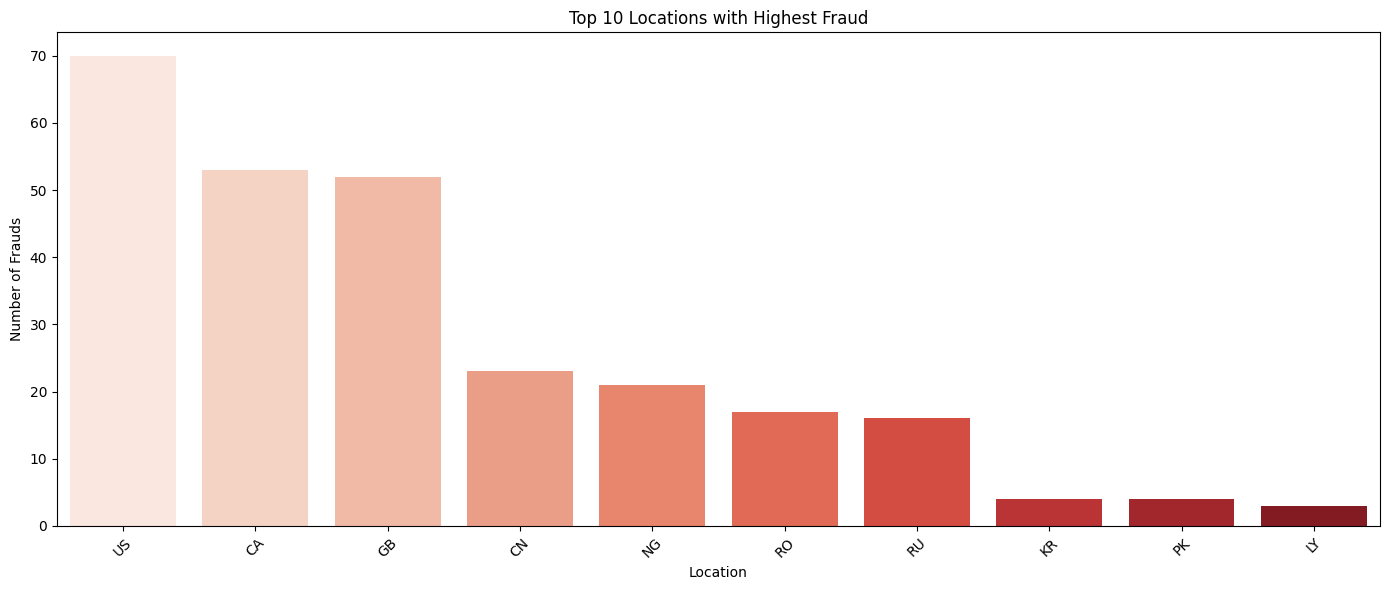

In [144]:
# Group by location
location_stats = df.groupby('location').agg(
    total=('is_fraud', 'count'),
    frauds=('is_fraud', 'sum')
)

# Compute proportion
location_stats['fraud_ratio'] = location_stats['frauds'] 

# Take top 10 locations with highest frauds
top_fraud_locations = location_stats.sort_values('fraud_ratio', ascending=False).head(10)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    x=top_fraud_locations.index,
    y=top_fraud_locations['fraud_ratio'],
    palette='Reds',
    hue=top_fraud_locations.index
)

plt.title('Top 10 Locations with Highest Fraud')
plt.xlabel('Location')
plt.ylabel('Number of Frauds')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
